# Imports

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable

# Hydrogen Atom

We will start by studying the Hydrogen Atom:

$$
\begin{align*}

H &= -\frac12\nabla^2 - \frac1r
\\\\


\psi(\textbf r) &= e^{-\beta r}

\end{align*}
$$

# Metropolis Sampling Position

In [17]:
def rvec(pos: np.ndarray) -> float:
    return np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)


def r3(x: float, y: float, z:float) -> float:
    return np.sqrt(x**2 + y**2 + z**2)


def samplePos(M: int, beta: float, delta: float = 0.5) -> np.ndarray:
    """
        Samples M positions taking as the desired distribution psi, assuming psi is real!
    """

    # List of samples
    samples = np.zeros((M), dtype=float)

    # Starting position
    x, y, z = 10, 0.1, 0.01
    rpos = r3(x, y, z)
    samples[0] = rpos

    logpsi = -beta * rpos

    # Metropolis Loop
    succ = 0
    for attempt in range(M-1):
        xp = x + delta*(np.random.random() - 0.5)
        yp = y + delta*(np.random.random() - 0.5)
        zp = z + delta*(np.random.random() - 0.5)

        rposp = r3(xp, yp, zp)
        logpsip = -beta * rposp

        accept = min(1, np.exp(2 * (logpsip - logpsi)))

        # Accept step
        if accept > np.random.random():
            succ += 1

            x, y, z = xp, yp, zp
            rpos = rposp
            logpsi = logpsip
        
        # Save state
        samples[attempt+1] = rpos
    
    print(f"Acceptance: {succ / attempt}")
    return samples

In [18]:
def sampleNeff(data: np.ndarray, k1: int = 0, icutoff: int = 200) -> int:
    # Equilibriation
    data = data[k1:]

    # Raw data
    Neq = len(data)

    # Calculate Stats
    ave = np.mean(data)
    var = np.var(data, mean=ave, ddof=1)

    # Calculate autocorrelations and cutoff
    autocorr = np.array([np.mean((data[: Neq-i]-ave) * (data[i:]-ave)) for i in range(1, icutoff+1)]) / (var)

    # Calculate autocorrelation time (sum until we find some negative number)
    timecorr = 1 + 2 * np.sum(autocorr * (np.arange(len(autocorr)) < np.argmax(autocorr < 0)))

    Neff = Neq / timecorr

    return ave, var, timecorr, Neff

## No Reweighting

Beta = 0.200
Acceptance: 0.8917855714095213
Energy = -0.1813984988451705
Variance on Energy = 0.019919812609025422
Correlation Time: 1.0
Neff: 13500.0
Standard Deviation on Mean Energy = 0.0012147187636414546

Beta = 0.300
Acceptance: 0.8295772769702627
Energy = -0.24958827258261132
Variance on Energy = 0.038690730744176595
Correlation Time: 29.231448517531643
Neff: 461.8313728758032
Standard Deviation on Mean Energy = 0.009152963915237256

Beta = 0.400
Acceptance: 0.777970396052807
Energy = -0.31448247884643316
Variance on Energy = 0.048073862162754874
Correlation Time: 21.17465083098287
Neff: 637.5547869836287
Standard Deviation on Mean Energy = 0.008683518852328855

Beta = 0.500
Acceptance: 0.7282304307240965
Energy = -0.3828125574638037
Variance on Energy = 0.06894906083797395
Correlation Time: 16.403449730193337
Neff: 822.9976146512008
Standard Deviation on Mean Energy = 0.009153030072664048

Beta = 0.600
Acceptance: 0.6886918255767436
Energy = -0.4025350626364535
Variance on Ener

/tmp/ipykernel_1085/3773701406.py:13: RuntimeWarning: invalid value encountered in divide
  autocorr = np.array([np.mean((data[: Neq-i]-ave) * (data[i:]-ave)) for i in range(1, icutoff+1)]) / (var)


Energy = -0.5
Variance on Energy = 0.0
Correlation Time: nan
Neff: nan
Standard Deviation on Mean Energy = nan

Beta = 1.100
Acceptance: 0.472996399519936
Energy = -0.49570825581746214
Variance on Energy = 0.011253989059403197
Correlation Time: 12.345676170838985
Neff: 1093.500251682251
Standard Deviation on Mean Energy = 0.0032080697387538047

Beta = 1.200
Acceptance: 0.4285904787304974
Energy = -0.47294370961973753
Variance on Energy = 0.04356958075851557
Correlation Time: 14.302438430325662
Neff: 943.8949914565449
Standard Deviation on Mean Energy = 0.006794067380654383

Beta = 1.300
Acceptance: 0.40312041605547405
Energy = -0.46749859905368424
Variance on Energy = 0.10086233725740966
Correlation Time: 17.191998343407118
Neff: 785.2490286667027
Standard Deviation on Mean Energy = 0.011333415473694352

Beta = 1.400
Acceptance: 0.37638351780237367
Energy = -0.41068951201738685
Variance on Energy = 0.3049380167566346
Correlation Time: 19.02539683661165
Neff: 709.5778403960113
Standard 

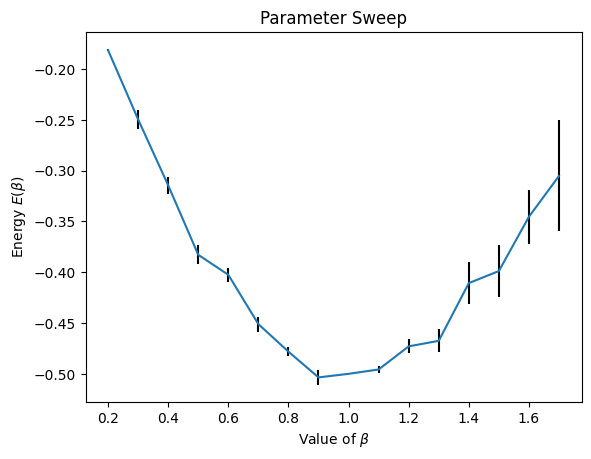

In [22]:
# Parameters
sampleM = 15000
discard = 1500
delta = 2.4

# Sweep Variational Parameter
betaMin = 0.2
betaMax = 1.7

Ebeta = []
Estd = []
Evar = []
bbRange = np.linspace(betaMin, betaMax, 16)
for betaStart in bbRange:
    print(f"Beta = {betaStart:.3f}")
    Rs = samplePos(sampleM, betaStart, delta)
    Rs = Rs[discard:]
    Ekin = -0.5*betaStart*(betaStart - 2/Rs)
    Epot = - 1.0 / Rs
    El = Ekin + Epot
    ave, var, timecorr, Neff = sampleNeff(El)

    with open(f"./Outputs/h-out-beta={betaStart:.2f}.txt", "w") as file:
        for i in range(len(El)):
            file.write(f"{El[i]}\t{Ekin[i]}\t{Epot[i]}\n")

    Evar += [var]
    Estd += [np.sqrt(var) / np.sqrt(Neff)]
    Ebeta += [ave]
    print(f"Energy = {Ebeta[-1]}")
    print(f"Variance on Energy = {Evar[-1]}")
    print(f"Correlation Time: {timecorr}")
    print(f"Neff: {Neff}")
    print(f"Standard Deviation on Mean Energy = {Estd[-1]}")
    print("")

print(f"Best beta: {bbRange[Ebeta.index(np.min(Ebeta))]}")
plt.errorbar(bbRange, Ebeta, yerr=Estd, ecolor="black")
plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")

plt.savefig(f"./Plots/h-out-sweep.png")

# With Reweighting

BetaMid = 2.000
Acceptance: 0.4529921653608935


/tmp/ipykernel_1085/304313310.py:46: RuntimeWarning: invalid value encountered in sqrt
  Estd += [np.std(El) / np.sqrt(Neff)]


ValueError: 'yerr' (shape: (9, 4)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (9,))

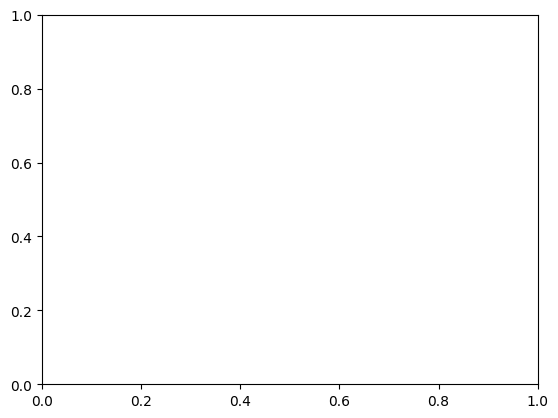

In [20]:
# Sampling Parameters
sampleM = 12000
discard = 2000

delta = 1.4

# Target Function is energy + stdW * std
stdW = 2

# Starting Variational Parameters
betaStart = 2

betaRange = 1
betaSamples = 11
betaMult = 0.5

betaSteps = 5

betaMid = betaStart
for _ in range(betaSteps):
    betaMin = betaMid - betaRange
    betaMax = betaMid + betaRange

    Ebeta = []
    Estd = []
    bb = []
    bbRange = np.linspace(betaMin, betaMax, betaSamples)
    
    print(f"BetaMid = {betaMid:.3f}")
    Rs = samplePos(sampleM, betaMid, delta=delta)
    Rs = Rs[discard:]
    El = -0.5*betaMid*(betaMid - 2/Rs) - 1.0 / Rs
    Neff = sampleNeff(El)
    for beta in bbRange:
        # Calculate weights
        ww = np.exp(-2 * (beta - betaMid) * Rs)

        # Effective number of points
        m = ((np.sum(ww))**2 / np.sum(ww**2)) / len(Rs)
        if m < 0.5:
            continue

        bb += [beta]

        El = -0.5*beta*(beta - 2/Rs) - 1.0 / Rs
        Estd += [np.std(El) / np.sqrt(Neff)]
        Ebeta += [(np.sum(El * ww)) / (np.sum(ww))]
    
    # Plot results
    plt.errorbar(bb, Ebeta, yerr=Estd, ecolor="black", label=f"BetaMid = {betaMid:.4f}")
    
    # Target function
    target = [Ebeta[i] + stdW * Estd[i] for i in range(len(bb))]

    betaMini = bb[target.index(min(target))]
    betaMid = betaMini
    betaRange *= betaMult
    print("")


print(f"Final beta: {betaMini}")
print(f"Minimum energy: {min(Ebeta)}")

plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")
plt.legend()